In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re 
import spacy
import spacy.cli
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from gensim.models import LdaModel
from gensim import corpora
from gensim.models import LdaMulticore
from gensim.parsing.preprocessing import STOPWORDS
import gensim
from pprint import pprint
from collections import defaultdict
import contractions

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

# spacy.cli.download('en_core_web_md')
nlp = spacy.load("en_core_web_md")

pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package punkt to C:\Users\York
[nltk_data]     Yong\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\York
[nltk_data]     Yong\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to C:\Users\York
[nltk_data]     Yong\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [40]:
df = pd.read_csv('../data/cleaned_data.csv')

In [41]:
df.head()

,store_address,location,reviewer_id,review_time,actual_sentiment,review,token_review_clean
0,"621 Broadway, Newark, NJ 07104, United States",7104,19164,5 days ago,negative,"Every single time I order on Uber eats or DoorDash or even go to the Drive thru, part of my order is missing. I call to speak to the manager and all I get is attitude. This is an issue as not always do these delivery app���������������������������s refund you. Or to drive back isn���������������������������t something you can always do.\n\nAs someone who was manager at one of the top McDonald���������������������������",every single time uber eats doordash even go drive thru part missing call speak manager get attitude issue always delivery apps refund drive back isnt something always someone manager one top
1,"621 Broadway, Newark, NJ 07104, United States",7104,27527,6 days ago,negative,"Every single time I order on Uber eats or DoorDash or even go to the Drive thru, part of my order is missing. I call to speak to the manager and all I get is attitude. This is an issue as not always do these delivery app���������������������������s refund you. Or to drive back isn���������������������������t something you can always do.\n\nAs someone who was manager at one of the top McDonald���������������������������",every single time uber eats doordash even go drive thru part missing call speak manager get attitude issue always delivery apps refund drive back isnt something always someone manager one top
2,"621 Broadway, Newark, NJ 07104, United States",7104,19183,3 months ago,negative,Horrible service from the night shift manager .!! I would also love to speak to a distric manager.!,horrible service night shift manager would also love speak distric manager
3,"621 Broadway, Newark, NJ 07104, United States",7104,19162,2 weeks ago,negative,"I only eat at this specific location when I don���������������������������t have time to travel elsewhere. The McDonalds at Newark Penn Station AND Broad & Market street got way better service than this one. No one speaks English, so there�������",eat specific dont time travel elsewhere newark penn station broad market street got way better service one one speaks english
4,"621 Broadway, Newark, NJ 07104, United States",7104,19165,3 weeks ago,negative,"It sucks because this place does have good staff, but there���������������������������s also staff that just doesn���������������������������t care. I ordered an iced caramel frapuccino in the drive thru, they asked me to park and had someone bring a hot frappe. I told the woman it should���������������������������v",suck place good staff there also staff doesnt care ordered iced caramel frapuccino drive thru asked park someone bring hot frappe told woman shouldv


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2539 entries, 0 to 2538
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   store_address       2539 non-null   object
 1   location            2539 non-null   int64 
 2   reviewer_id         2539 non-null   int64 
 3   review_time         2539 non-null   object
 4   actual_sentiment    2539 non-null   object
 5   review              2539 non-null   object
 6   token_review_clean  2532 non-null   object
dtypes: int64(2), object(5)
memory usage: 139.0+ KB


In [43]:
df[df['token_review_clean'].isnull()]

,store_address,location,reviewer_id,review_time,actual_sentiment,review,token_review_clean
561,"1044 US-11, Champlain, NY 12919, United States",12919,12074,6 months ago,neutral,Same as any other McDonald's,NaN
646,"1916 M St NW, Washington, DC 20036, United States",20036,9385,6 months ago,negative,Isn���������������,NaN
1273,"11382 US-441, Orlando, FL 32837, United States",32837,8167,4 months ago,positive,it's MCDonald !,NaN
1337,"3501 Biscayne Blvd, Miami, FL 33137, United States",33137,32879,2 months ago,neutral,It's McDonald's.,NaN
1718,"2400 Alliance Gateway Fwy, Fort Worth, TX 76177, United States",76177,20322,4 months ago,positive,It��������������,NaN
1794,"25200 I-10 Lot 2, San Antonio, TX 78257, United States",78257,14422,6 months ago,neutral,Same as them all!,NaN
2302,"1540 2nd St, Santa Monica, CA 90405, United States",90405,12992,a week ago,positive,It���������������������������s McDonald���������������������������s,NaN


In [44]:
df = df.dropna(subset=['token_review_clean'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2532 entries, 0 to 2538
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   store_address       2532 non-null   object
 1   location            2532 non-null   int64 
 2   reviewer_id         2532 non-null   int64 
 3   review_time         2532 non-null   object
 4   actual_sentiment    2532 non-null   object
 5   review              2532 non-null   object
 6   token_review_clean  2532 non-null   object
dtypes: int64(2), object(5)
memory usage: 158.2+ KB


### Text Cleaning

In [45]:
# Function for text cleaning
def clean_text(text):
   
    # Expand contractions
    text = contractions.fix(text)
    
    # Convert text to lowercase
    text = text.lower()
    
    # Remove special characters and punctuation
    text = re.sub(r"[^a-zA-Z0-9\s']", '', text)
    
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply the cleaning function to the 'review' column
df['cleaned_review'] = df['review'].apply(clean_text)

# Display the first few rows of the updated DataFrame
df[['review', 'cleaned_review']].head()

,review,cleaned_review
0,"Every single time I order on Uber eats or DoorDash or even go to the Drive thru, part of my order is missing. I call to speak to the manager and all I get is attitude. This is an issue as not always do these delivery app���������������������������s refund you. Or to drive back isn���������������������������t something you can always do.\n\nAs someone who was manager at one of the top McDonald���������������������������",every single time i order on uber eats or doordash or even go to the drive thru part of my order is missing i call to speak to the manager and all i get is attitude this is an issue as not always do these delivery apps refund you or to drive back isnt something you can always do as someone who was manager at one of the top mcdonald
1,"Every single time I order on Uber eats or DoorDash or even go to the Drive thru, part of my order is missing. I call to speak to the manager and all I get is attitude. This is an issue as not always do these delivery app���������������������������s refund you. Or to drive back isn���������������������������t something you can always do.\n\nAs someone who was manager at one of the top McDonald���������������������������",every single time i order on uber eats or doordash or even go to the drive thru part of my order is missing i call to speak to the manager and all i get is attitude this is an issue as not always do these delivery apps refund you or to drive back isnt something you can always do as someone who was manager at one of the top mcdonald
2,Horrible service from the night shift manager .!! I would also love to speak to a distric manager.!,horrible service from the night shift manager i would also love to speak to a distric manager
3,"I only eat at this specific location when I don���������������������������t have time to travel elsewhere. The McDonalds at Newark Penn Station AND Broad & Market street got way better service than this one. No one speaks English, so there�������",i only eat at this specific location when i dont have time to travel elsewhere the mcdonalds at newark penn station and broad market street got way better service than this one no one speaks english so there
4,"It sucks because this place does have good staff, but there���������������������������s also staff that just doesn���������������������������t care. I ordered an iced caramel frapuccino in the drive thru, they asked me to park and had someone bring a hot frappe. I told the woman it should���������������������������v",it sucks because this place does have good staff but theres also staff that just doesnt care i ordered an iced caramel frapuccino in the drive thru they asked me to park and had someone bring a hot frappe i told the woman it shouldv


## Use Latent Dirichlet Allocation(LDA) to identify aspect keywords

In [46]:
# Preprocess text for LDA
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in STOPWORDS and len(token) > 2:
            result.append(token)
    return result

In [47]:
# Perform LDA to identify topics (aspects)
def identify_aspects_lda(df, num_topics=10):
    texts = df['review'].apply(preprocess)
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100,
                         update_every=1, chunksize=200, passes=50, alpha='auto', per_word_topics=True)
    
    topics = lda_model.print_topics(num_words=5)
    aspect_keywords = [", ".join([word.split("*")[1].strip().strip('"') for word in topic[1].split("+")]) for topic in topics]
    return aspect_keywords

In [48]:
# Identify aspects using LDA
aspect_keywords = identify_aspects_lda(df)

In [49]:
aspect_keywords

['clean, fresh, quick, neutral, ice',
 'love, big, mac, dirty, prices',
 'slow, super, counter, away, sandwich',
 'excellent, half, phone, years, thank',
 'food, service, staff, great, fast',
 'mcdonald, good, place, like, long',
 'seen, recommend, management, answer, things',
 'breakfast, pay, sure, new, stars',
 'order, drive, time, location, minutes',
 'got, ordered, fries, asked, came']

## Use Latent Dirichlet Allocation(LDA) multicore to identify aspect keywords

In [50]:
# Perform LDA to identify topics (aspects)
def identify_aspects_lda(df, num_topics=10):
    texts = df['review'].apply(preprocess)
    id2word = corpora.Dictionary(texts)
    corpus = [id2word.doc2bow(text) for text in texts]
    
    lda_model = LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics, 
                             iterations=400, passes=20, workers=4)
    
    pprint(lda_model.print_topics())
    
    # Extract keywords for each topic
    aspect_keywords = []
    for idx, topic in lda_model.print_topics(-1):
        keywords = [word.split("*")[1].strip().strip('"') for word in topic.split("+")]
        aspect_keywords.append(", ".join(keywords))
    
    return aspect_keywords, lda_model, corpus

In [51]:
# Identify aspects using LDA
aspect_keywords_multicore, lda_model, corpus = identify_aspects_lda(df)
aspect_keywords_multicore

[(0,
  '0.038*"terrible" + 0.035*"service" + 0.033*"slow" + 0.028*"bad" + '
  '0.009*"food" + 0.008*"sandwich" + 0.007*"staff" + 0.007*"order" + '
  '0.007*"fish" + 0.006*"employees"'),
 (1,
  '0.025*"order" + 0.017*"closed" + 0.013*"mcdonald" + 0.013*"drive" + '
  '0.012*"open" + 0.011*"staff" + 0.010*"hours" + 0.009*"said" + 0.009*"food" '
  '+ 0.009*"place"'),
 (2,
  '0.033*"neutral" + 0.031*"friendly" + 0.030*"fast" + 0.024*"service" + '
  '0.020*"staff" + 0.015*"order" + 0.015*"quick" + 0.011*"food" + 0.011*"long" '
  '+ 0.009*"time"'),
 (3,
  '0.037*"order" + 0.018*"great" + 0.015*"told" + 0.014*"food" + '
  '0.011*"service" + 0.009*"place" + 0.009*"got" + 0.009*"minutes" + '
  '0.009*"time" + 0.009*"ice"'),
 (4,
  '0.033*"food" + 0.014*"service" + 0.013*"poor" + 0.011*"time" + '
  '0.010*"order" + 0.008*"people" + 0.008*"cold" + 0.008*"drive" + '
  '0.007*"asked" + 0.006*"homeless"'),
 (5,
  '0.026*"mcdonald" + 0.022*"best" + 0.016*"place" + 0.012*"service" + '
  '0.011*"kids" +

['terrible, service, slow, bad, food, sandwich, staff, order, fish, employees',
 'order, closed, mcdonald, drive, open, staff, hours, said, food, place',
 'neutral, friendly, fast, service, staff, order, quick, food, long, time',
 'order, great, told, food, service, place, got, minutes, time, ice',
 'food, service, poor, time, order, people, cold, drive, asked, homeless',
 'mcdonald, best, place, service, kids, food, great, drive, menu, visit',
 'order, food, mcdonald, people, minutes, like, service, manager, rude, location',
 'food, clean, service, fries, fresh, staff, good, nice, place, mcdonald',
 'mcdonald, good, food, pizza, excellent, place, service, pasta, like, arcade',
 'order, drive, got, ordered, food, time, orders, minutes, waited, wrong']

## Identify aspect keywords

Based on the above two LDA methods we can determine the following as the key aspect words

- Food Quality
- Service
- Speed
- Cleaniness
- Order Accuracy
- Atmosphere
- Pricing
- General

In [218]:
# Define aspects and their related terms
aspect_categories = {
    'food': ['fries', 'fresh', 'ice', 'cream', 'sandwich', 'breakfast', 'pizza', 'nugget', 'burger','breakfast','lunch','dinner'],
    'service': ['service', 'staff', 'manager', 'friendly', 'polite', 'recommend', 'management'],
    'speed': ['quick', 'slow', 'super', 'long', 'minutes', 'fast'],
    'cleanliness': ['clean', 'dirty'],
    'order': ['order', 'drive', 'machine', 'ordered', 'counter', 'came'],
    'price': ['price', 'pay', 'cheap', 'affordable', 'expensive']
}

# Precompute aspect vectors
aspect_vectors = {aspect: nlp(" ".join(terms)) for aspect, terms in aspect_categories.items()}

#### Modified from EDA

In [219]:
# # Define the topic keyword lists (for classification)
# topics_keywords = {
#     'service': ['professional', 'unprofessional', 'staff', 'customer', 'support', 'help', 'rude', 'polite', 'friendly'],
#     # 'quality': ['quality', 'good', 'bad', 'excellent', 'fantastic', 'terrible', 'poor', 'great', 'worst'],
#     'price': ['expensive', 'cheap', 'worth', 'money', 'cost', 'value'],
#     'order': ['delivery', 'missing', 'arrive', 'time', 'late', 'fast', 'delay', 'thru'],
#     'cleanliness': ['clean', 'dirty', 'messy', 'hygiene', 'bathroom', 'toilet', 'restroom', 'smell'],
#     'food': ['cold', 'delicious', 'yummy', 'spoilt', 'disgusting', 'burger', 'pie', 'chicken', 'meal', 'fries', 'fish', 'frappe', 'nugget', 'soda'],
#     # 'facilities': ['play', 'thru', 'drive']
# }

# # Precompute aspect vectors
# aspect_vectors = {aspect: nlp(" ".join(terms)) for aspect, terms in topics_keywords.items()}

In [234]:
def identify_aspects(review, threshold=0.6):
    review_doc = nlp(review)
    identified_aspects = defaultdict(list)
    
    for token in review_doc:
        if token.has_vector:
            for aspect, aspect_vector in aspect_vectors.items():
                similarity = token.similarity(aspect_vector)
                if similarity > threshold:
                    identified_aspects[aspect].append((token.text, token.i, similarity))
    
    # Sort and keep only the highest similarity match for each aspect
    result = []
    for aspect, matches in identified_aspects.items():
        if matches:
            best_match = max(matches, key=lambda x: x[2])
            result.append((aspect, best_match[1]))  # aspect and token index
    
    return result

In [235]:
def get_relevant_text(review, aspect, aspect_index, window_size=5):
    doc = nlp(review)
    start = max(0, aspect_index - window_size)
    end = min(len(doc), aspect_index + window_size + 1)
    return doc[start:end].text

In [236]:
review = "mediocre service at this location huge language barrier as most staff are not fluent in english nothing against them for this but they do give very poor service"
aspect_test = identify_aspects(review)


print(identify_aspects(review))

[('service', 1)]


In [237]:
relevant_text3 = get_relevant_text(review, 'service', 1)
relevant_text3

'mediocre service at this location huge language'

## Obtain sentiment for a given text

#### Method 1

In [238]:
# Function to get sentiment for a given text
def get_sentiment(text):
    sia = SentimentIntensityAnalyzer()
    sentiment_scores = sia.polarity_scores(text)
    if sentiment_scores['compound'] >= 0.001:
        return 'positive'
    elif sentiment_scores['compound'] <= -0.001:
        return 'negative'
    else:
        return 'neutral'

In [239]:
text = 'mediocre service at this'
sia = SentimentIntensityAnalyzer()

sia.polarity_scores(text)

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [240]:
get_sentiment(text)

'neutral'

#### Method 2

In [241]:
from textblob import TextBlob

# Function to get sentiment using TextBlob
def get_sentiment(text):
    blob = TextBlob(text)
    sentiment_polarity = blob.sentiment.polarity
    if sentiment_polarity > 0:
        return 'positive'
    elif sentiment_polarity < 0:
        return 'negative'
    else:
        return 'neutral'

In [242]:
text = 'mediocre service at this'

get_sentiment(text)

'negative'

## Process the Dataframe

In [243]:
# Process the dataframe
results = []
for _, row in df.iterrows():
    review = row['cleaned_review']
    identified_aspects = identify_aspects(review)
    
    if not identified_aspects:
        new_row = row.copy()
        new_row['aspect'] = 'general'
        new_row['aspect_sentiment'] = get_sentiment(review)
        results.append(new_row)
    else:
        for aspect, aspect_index in identified_aspects:
            relevant_text = get_relevant_text(review, aspect, aspect_index)
            new_row = row.copy()
            new_row['aspect'] = aspect
            new_row['aspect_index'] = aspect_index
            new_row['aspect_sentiment'] = get_sentiment(relevant_text)
            results.append(new_row)

In [244]:
# Create a new dataframe with the results
new_df = pd.DataFrame(results)

In [252]:
new_df[200:210]

,store_address,location,reviewer_id,review_time,actual_sentiment,review,token_review_clean,cleaned_review,aspect,aspect_index,aspect_sentiment
145,"490 8th Ave, New York, NY 10001, United States",10001,6560,6 months ago,negative,Shittyy slow service,shittyy slow service,shittyy slow service,speed,1.0,negative
145,"490 8th Ave, New York, NY 10001, United States",10001,6560,6 months ago,negative,Shittyy slow service,shittyy slow service,shittyy slow service,service,2.0,negative
146,"429 7th Ave, New York, NY 10001, United States",10001,3015,4 months ago,negative,"Staff is slow and rude, restrooms are not available",staff slow rude restroom available,staff is slow and rude restrooms are not available,service,0.0,negative
146,"429 7th Ave, New York, NY 10001, United States",10001,3015,4 months ago,negative,"Staff is slow and rude, restrooms are not available",staff slow rude restroom available,staff is slow and rude restrooms are not available,speed,2.0,negative
147,"490 8th Ave, New York, NY 10001, United States",10001,6395,3 months ago,negative,STOP EATING MCDONALD'S...PERIOD,stop eating mcdonald'speriod,stop eating mcdonald'speriod,general,NaN,neutral
148,"429 7th Ave, New York, NY 10001, United States",10001,3494,5 months ago,negative,Terrible,terrible,terrible,general,NaN,negative
149,"429 7th Ave, New York, NY 10001, United States",10001,3876,a week ago,negative,Terrible,terrible,terrible,general,NaN,negative
150,"490 8th Ave, New York, NY 10001, United States",10001,6383,3 months ago,negative,Terrible customer service!,terrible customer service,terrible customer service,service,2.0,negative
151,"151 West 34th Street (Macy's 7th Floor, New York, NY 10001, United States",10001,10036,2 months ago,negative,"Terrible place, computers failing massive line at front to order food, 1 till open, asked management for assistance as I am a diabetic\n\nNone offered nothing we can do for you managed to get food after 45 minutes!! I was lucky my wife got the food and took over the wait\n\nDon����������",terrible place computer failing massive line front till open asked management assistance diabetic none offered nothing managed get minute lucky wife got took wait,terrible place computers failing massive line at front to order food 1 till open asked management for assistance as i am a diabetic none offered nothing we can do for you managed to get food after 45 minutes i was lucky my wife got the food and took over the wait don,order,9.0,neutral
151,"151 West 34th Street (Macy's 7th Floor, New York, NY 10001, United States",10001,10036,2 months ago,negative,"Terrible place, computers failing massive line at front to order food, 1 till open, asked management for assistance as I am a diabetic\n\nNone offered nothing we can do for you managed to get food after 45 minutes!! I was lucky my wife got the food and took over the wait\n\nDon����������",terrible place computer failing massive line front till open asked management assistance diabetic none offered nothing managed get minute lucky wife got took wait,terrible place computers failing massive line at front to order food 1 till open asked management for assistance as i am a diabetic none offered nothing we can do for you managed to get food after 45 minutes i was lucky my wife got the food and took over the wait don,service,15.0,neutral


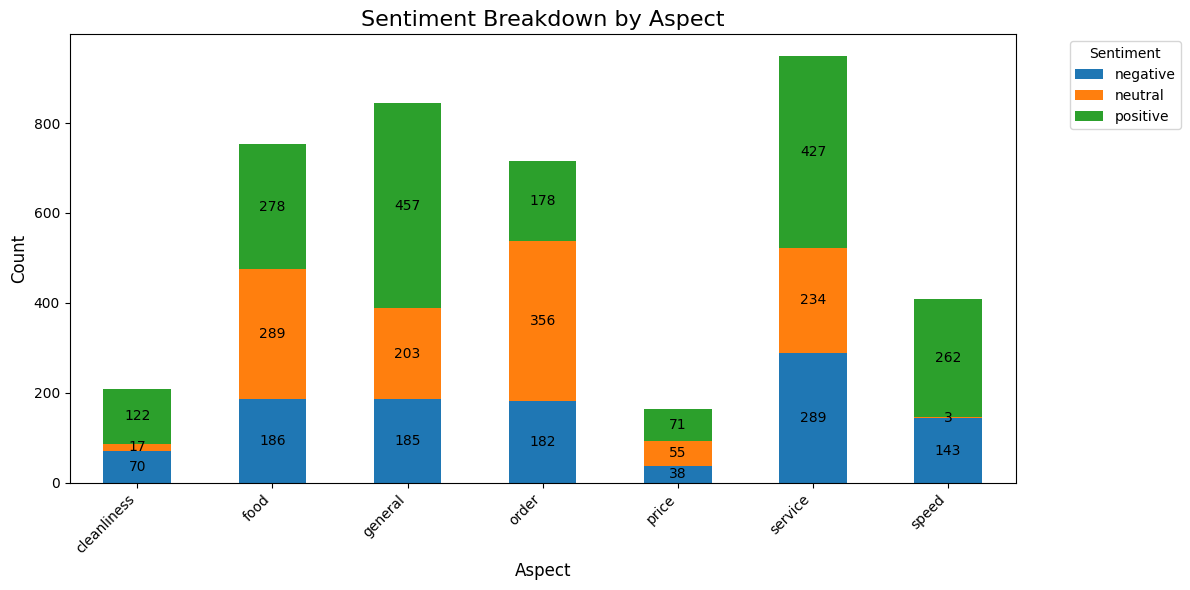

In [250]:
# Group the data by aspect and sentiment, and count occurrences
sentiment_counts = new_df.groupby(['aspect', 'aspect_sentiment']).size().unstack(fill_value=0)

# Create a stacked bar chart
ax = sentiment_counts.plot(kind='bar', stacked=True, figsize=(12, 6))

# Customize the plot
plt.title('Sentiment Breakdown by Aspect', fontsize=16)
plt.xlabel('Aspect', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')

# Add count labels on the bars
for c in ax.containers:
    ax.bar_label(c, fmt='%d', label_type='center')

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()